In [4]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import matplotlib.pyplot as plt
from BasicSetupUtilities.MetaDataBuilder import CountryMetaDataFile
from DataIOUtilities.DataLib import DataLib, DatastreamPulls
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler

countries = CountryMetaDataFile().readMetadata()
dl = DataLib("SignalData")

In [5]:
# Setting up Bond Return Index variables
BondReturnIndex = dl.pull('BondRetIdx/LocalFX') # daily, represents accumulated returns from holding 10-year bonds
average = 'Equal Weighted Mean'
std = 'Equal Weighted Std'
BondReturnIndex[average] = BondReturnIndex.mean(axis=1) # global average
MonthlyBondReturnIndex = BondReturnIndex.resample('1M').mean()
MonthlyBondReturnIndex[average] = MonthlyBondReturnIndex.mean(axis=1) # global average

# Indicator 1: Bond Premium

* What it is: difference between the long rate and short rate
* What it means: reflects the slope of the yield curve
* What it tells us: the greater the bond premium, the greater the spread between long and short rates
* What we expect: typically the bond premium is positive (meaning that long rates > short rates) since there is more risk associated with holding bonds for longer
* What this tells us about bonds: steepening yield curves attracts investors with long positions

/Users/veronicanutting/.local/share/virtualenvs/Internship2020-n3zEes1m/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


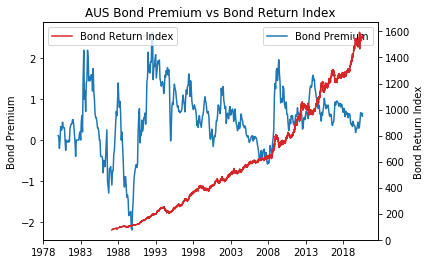

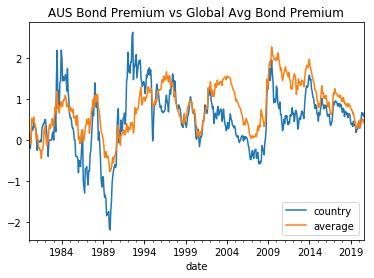

In [6]:
# Calculating Bond Premium for all countries
ShortRates = dl.pull('ShortRates') # monthly
LongRates = dl.pull('LongRates') # monthly, nominal yield on 10-year govenment issued bonds
BondPremium = LongRates - ShortRates
BondPremium[average] = BondPremium.mean(axis=1) # global average
BondPremium[std] = BondPremium.std(axis=1) # global std

country = 'AUS'

# Bond Premium vs. Bond Returns
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1_label = 'Bond Premium'
ax1.plot(BondPremium[country].to_timestamp(), label = ax1_label)
ax1.set_ylabel(ax1_label)
ax1.legend()
ax2_label = 'Bond Return Index'
ax2.plot(BondReturnIndex[country].to_timestamp(), color = 'tab:red', label = ax2_label)
ax2.set_ylabel(ax2_label)
ax2.legend()
plt.title(f'{country} Bond Premium vs Bond Return Index')
plt.show()

# Bond Premium vs. Global Avg Bond Premium
BondPremium[country].plot()
BondPremium[average].plot()
plt.legend(['country', 'average'])
plt.title(f'{country} Bond Premium vs Global Avg Bond Premium')
plt.show()

In [7]:
# Calculate and display P&L values from prediction dataframe
def PnLAnalysis(data, country):
    
    # Calculate P&L by re-ranging indicators to fall between -1 and 1
    data['pnlA'] = np.tanh(data['IndicatorA']) * data[country].shift(1).pct_change()
    data['pnlB'] = np.tanh(data['IndicatorB']) * data[country].shift(1).pct_change()
    data['pnlC'] = np.tanh(data['IndicatorC']) * data[country].shift(1).pct_change()
    
    # Plot P&L Curves
    data['pnlA'].cumsum().plot()
    data['pnlB'].cumsum().plot()
    data['pnlC'].cumsum().plot()
    plt.legend(['pnlA', 'pnlB', 'pnlC'])
    plt.title(f'{country} P&L Curves')
    plt.show()
    
    return data

# LOGIC
* The bigger the Bond Premium, the steeper the yield curve, the bigger our long position
* If the Bond Premium is relatively bigger, our position should be positive (long)
* Curve is steepening if premium at given day is greater than some rolling average
* We can scale our Bond Premium by whether or not it is steepening before standardizing

In [8]:
# Takes in a country and returns prediction dataframe
def BondPremiumIndicator(country):
    
    # Set up monthly country data
    data = pd.DataFrame(MonthlyBondReturnIndex[country])
    data['BondPremium'] = BondPremium[country]
    
    # Prediction A: Prediction scaled by domestic change in BP over 6-month period
    # Standardize this month's BP relative to past BP within country withing 6M window
    data['IndicatorA'] = (data['BondPremium'] - data['BondPremium'].rolling(4*12).mean()) / data['BondPremium'].rolling(4*12).std() 
        
    # Prediction B: Prediction scaled by global average
    data['GlobalAvg'] = BondPremium[average]
    data['GlobalStd'] = BondPremium[std]
    data['IndicatorB'] = (data['BondPremium'] - data['GlobalAvg']) / data['GlobalStd'] 

    # Prediction C: Prediction scaled by global average
    # Standardize this month's BP relative to past BP global average withing 6M window
    data['IndicatorC'] = (data['BondPremium'] - data['GlobalAvg'].rolling(4*12).mean()) / data['GlobalAvg'].rolling(4*12).std() 

    # Calculate P&L
    data = PnLAnalysis(data, country)
    
    return data

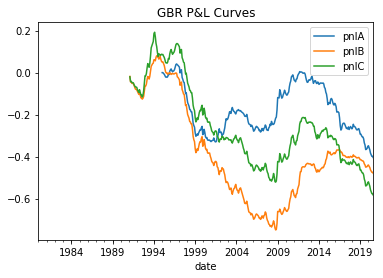

In [9]:
results = BondPremiumIndicator('GBR')

In [24]:
# Test all countries
def TestAll():

    resultsAll = pd.DataFrame()
    all_countries = ShortRates.columns

    for i in all_countries:
        resultCountry = BondPremiumIndicator(i)
        resultsAll[i] = [resultCountry['pnlA'].sum(),resultCountry['pnlB'].sum(),resultCountry['pnlC'].sum()]
        
    return resultsAll

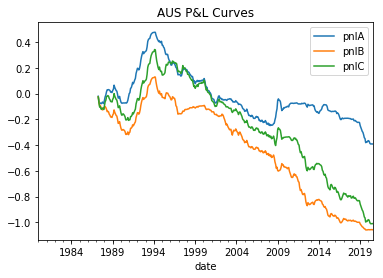

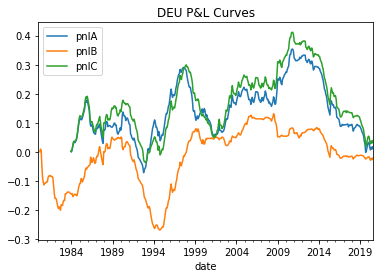

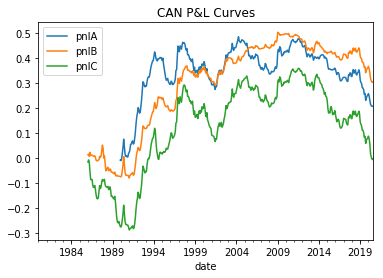

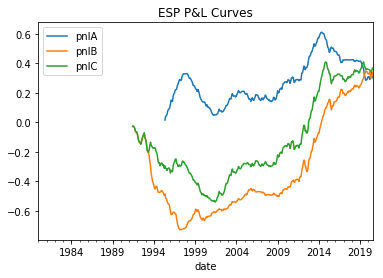

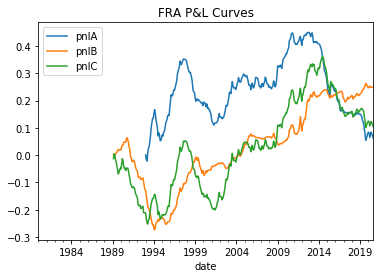

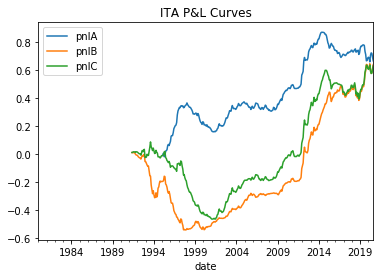

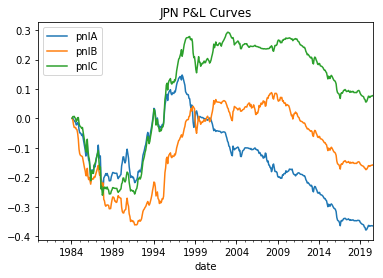

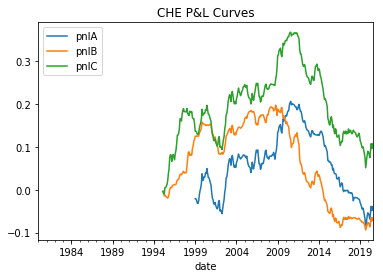

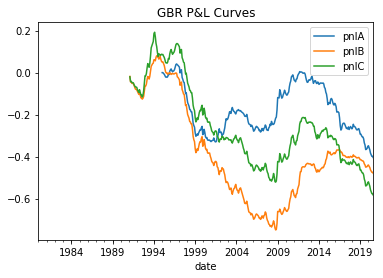

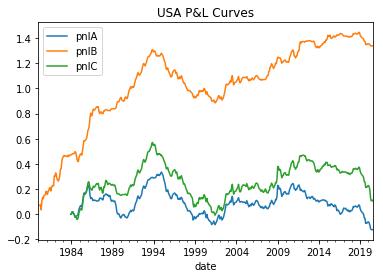

        AUS       DEU       CAN       ESP       FRA       ITA       JPN  \
0 -0.392309  0.011105  0.205977  0.297639  0.061913  0.668125 -0.365258   
1 -1.055681 -0.025906  0.301612  0.345588  0.249264  0.640987 -0.158340   
2 -1.012146  0.031853 -0.007097  0.366592  0.103938  0.632888  0.077067   

        CHE       GBR       USA  
0 -0.043719 -0.405264 -0.125979  
1 -0.068371 -0.480258  1.339725  
2  0.101847 -0.583903  0.101359  


,AUS,DEU,CAN,ESP,FRA,ITA,JPN,CHE,GBR,USA
0,-0.392309,0.011105,0.205977,0.297639,0.061913,0.668125,-0.365258,-0.043719,-0.405264,-0.125979
1,-1.055681,-0.025906,0.301612,0.345588,0.249264,0.640987,-0.158340,-0.068371,-0.480258,1.339725
2,-1.012146,0.031853,-0.007097,0.366592,0.103938,0.632888,0.077067,0.101847,-0.583903,0.101359


In [25]:
TestAll()